<a href="https://colab.research.google.com/github/yatowoo/Priconne/blob/main/pcr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Global data

In [46]:
from math import *
from random import uniform as rng
import numpy as np
import matplotlib.pyplot as plt

In [47]:
LV_MAX = 199
HIT_DAMAGE_LIMIT = 999999

### Character properties

In [48]:
# Properties of Luna

LUNA = {
    'attack': 15666 + (240 + 15 * LV_MAX),
    'critical': 1332,
    'defence_phys': 222,
    'defence_magic': 326,
    'hp': 24090,
    'tp_rise': 13,
    'tp_rest': 28
}

LUNA_4 = {
    'attack': 15093 + (15 + 15 * LV_MAX),
    'critical': 1332,
    'defence_phys': 198,
    'defence_magic': 302,
    'hp': 20535,
    'tp_rise': 13,
    'tp_rest': 28
}

LUNA_3 = {
    'attack': 14519 + (15 + 15 * LV_MAX),
    'critical': 1332,
    'defence_phys': 171,
    'defence_magic': 275,
    'hp': 16977,
    'tp_rise': 13,
    'tp_rest': 28
}


# Properties of Nyaru

NYARU = {
    'attack': 16235 + (240 + 15 * LV_MAX),
    'critical': 1367,
    'defence_phys': 236,
    'defence_magic': 298,
    'hp': 23855,
    'tp_rise': 13,
    'tp_rest': 17
}

NYARU_4 = {
    'attack': 15649 + (15 + 15 * LV_MAX),
    'critical': 1537,
    'defence_phys': 209,
    'defence_magic': 278,
    'hp': 20354,
    'tp_rise': 13,
    'tp_rest': 17
}

NYARU_3 = {
    'attack': 15064 + (15 + 15 * LV_MAX),
    'critical': 1537,
    'defence_phys': 180,
    'defence_magic': 256,
    'hp': 16850,
    'tp_rise': 13,
    'tp_rest': 17
}

# Nuneka
# Rank 12, TP equip ONLY, 12-1/3 + 12-3/5
NUNEKA_ATTACK = 7219 + (240 + 15 * LV_MAX)

### Skills and battle fomules

In [49]:
def tp_integer(tp_orignal, tp_rise):
  return round(tp_orignal * (1 + tp_rise/100.))

def yukari_tp(tp_rise, lv = LV_MAX):
  return tp_integer(75 + 2.5 *lv, tp_rise)

def miren_tp(tp_rise, lv = LV_MAX):
  return tp_integer(250 + 1.35 * lv, tp_rise)

def uzuki_tp(tp_rise, lv = LV_MAX):
  return tp_integer(50 + 0.3 * lv, tp_rise)

def nuneka_tp(tp_rise, lv = LV_MAX):
  return tp_integer(18 + 0.6 * lv, tp_rise)

def action_tp(tp_rise):
  return tp_integer(90, tp_rise)

def kill_tp(tp_rise):
  return tp_integer(200, tp_rise)

def hurt_tp_magic(damage, role):
  return hurt_tp(damage, role['hp'], role['defence_magic'],role['tp_rise'])

def hurt_tp(damage, hp, defence, tp_rise):
  return tp_integer(damage/(1+defence/100.) / hp * 500, tp_rise)

def hurt_for_UB(nActions, tpRise, tpRest, hpMAX, defence, otherTP = 0):
  tpAction = nActions * action_tp(tpRise)
  dTP = 1000 - 1000 * tpRest / 100 - tpAction - otherTP
  return dTP / 500 * hpMAX / (1+tpRise/100.) * (1+ defence/100.)

def LogBarrier(damage, threshold=850000, factor=100000):
    if(damage < threshold):
        return damage
    else:
        return (factor * log((damage-threshold)/factor + 1) + threshold)
  
def critical_rate(criVal, enemyLv, lv = LV_MAX):
    return (0.05 * criVal / 100 * lv / enemyLv)

def critical_damage(orignalDamage, rate, criticalDamageBuff = 0., criticalCoeff = 2.0, defense = 0):
    hit = 0
    if(rng(0,1) < rate ):
        hit = round(orignalDamage * criticalCoeff * (1 + criticalDamageBuff))
    else:
        hit = round(orignalDamage)
    return min(HIT_DAMAGE_LIMIT, hit / (1+defense/100.))

NYARU_UB_BUFF_COEFF = 0.1125
def nyaruUB(attackWithBuff, criticalWithBuff, criticalDamageBuff = 0., enemyLv = LV_MAX, lv = LV_MAX, detail=False, magic_defense = 0):
    # split in 10 parts = 1/13 * 9 + 4/13
    totalDamage = 0
    orignalDamage = 60 * (LV_MAX + 1 ) + 4.8 * attackWithBuff
    for i in ([1] * 9 + [4]):
        totalDamage += critical_damage(orignalDamage*i/13, critical_rate(criticalWithBuff, enemyLv, lv), criticalDamageBuff, defense=magic_defense)
    if detail:
        return [round(orignalDamage * 1/13), round(orignalDamage * 4/13), totalDamage]
    else:
        return totalDamage

def NyaruS1(attackWithBuff, enemyDefense, criticalWithBuff, criticalDamageBuff =0., enemyLv = LV_MAX, lv = LV_MAX):
   original = 27 * (LV_MAX + 1) + 2.1 * attackWithBuff
   damage = critical_damage(original, critical_rate(criticalWithBuff, enemyLv, lv), criticalDamageBuff)
   return damage

def LunaS1(attackWithBuff, enemyDefense, criticalWithBuff, criticalDamageBuff = 0., enemyLv = LV_MAX, lv = LV_MAX):
    return round(critical_damage(attackWithBuff, critical_rate(criticalWithBuff, enemyLv, lv), criticalDamageBuff, defense=enemyDefense))


#### Test : Nyaru UB damage distribution
Nyaru's UB is splitted into 10 hits, including the first 9 hits took 1/13 damage and the last hit took 4/13. For simplicity, I suppose the critical for each hit is calculated independently. 

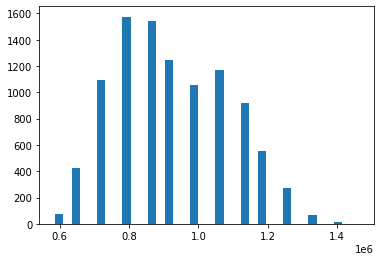

In [50]:
nyaruTest = lambda x : nyaruUB(NYARU['attack'] + x, NYARU['critical']+180,0.25,400)
a = [nyaruTest(100000) for i in range(0,10000)]
_ = plt.hist(a, bins='auto')

Nyaru UB to reach digit barrier without log barrier. Require around **24M** damage by UB in last 18 seconds.

In [51]:
totalDamageIn18s = (999999*13/4.8-NYARU['attack'])/NYARU_UB_BUFF_COEFF
d = nyaruUB(NYARU['attack'] + totalDamageIn18s*NYARU_UB_BUFF_COEFF, NYARU['critical'],0.15,400, LV_MAX, True)
print(d)
print(d[0]*9 + 999999)
print(totalDamageIn18s)

[1000922, 4003688, 9999990]
10008297
23901072.22222222


#### Test: Damage needed for UB 

In [52]:
# Nyaru with Yukari and Luna at 1:18
chara = NYARU_4
hurtNyaru = hurt_for_UB(2, chara['tp_rise'], 0, chara['hp'], chara['defence_magic'], yukari_tp(chara['tp_rise']))

### TP interger check

In [53]:
tp_cache = 1.10
tp_charge = 107.9
tp_charge_int = 108

for i in range(0,20):
    tp_up_tmp = tp_cache + 0.01 * i
    print('%.2f %.2f %.2f' % (tp_up_tmp, tp_charge * tp_up_tmp, tp_charge_int * tp_up_tmp))

1.10 118.69 118.80
1.11 119.77 119.88
1.12 120.85 120.96
1.13 121.93 122.04
1.14 123.01 123.12
1.15 124.09 124.20
1.16 125.16 125.28
1.17 126.24 126.36
1.18 127.32 127.44
1.19 128.40 128.52
1.20 129.48 129.60
1.21 130.56 130.68
1.22 131.64 131.76
1.23 132.72 132.84
1.24 133.80 133.92
1.25 134.88 135.00
1.26 135.95 136.08
1.27 137.03 137.16
1.28 138.11 138.24
1.29 139.19 139.32


## Damage limit with log barrier
After the Nyaru shock in the clan battle of 2020/01, Cygames decided to add a new limitation sign for all the bossed under clan battle mode. According to unpaced data from server, the mechanism is deployed with a simple logarithm for damage above threshold, so called **'log barrier**'.

The logarithm can be manipulated with two parameters, threshold and attenuation coefficient. Latest value in 2021/04 is **850,000** and 100,000.

### Example: Kaya vs Wyvern (2nd phase) 2021/01
[video](https://www.youtube.com/watch?v=DA6hy8W1RTQ) from たつきちゃん

In [54]:
eff_lv = 187
kaya_attack = 17337
damage_final = 856088
buff_miren = (18+2.5) * (eff_lv +1)
buff_self = (20 *2 + 72) * (1 + eff_lv)

damage = (120 * (eff_lv +1 ) + 9.6 * (kaya_attack + buff_miren + buff_self)) *2
print(int(damage), int(LogBarrier(damage)), int (damage_final))

856262 856074 856088


### UB with multi-hits
The method for multi-hit UB is still unclear. Here I suppose the possible process: 
1.   compute original damage without critical
2.   divide the orignal damage into hits
3.   define critical flags for hits
4.   sum the total damge and apply log barrier
5.   get a ratio of the total damage before and after
6.   apply the ratio to each hit

### Example: working with digit barrier
Another case is from the limitation of hit damage (digit barrier). If Nyaru get more than 320,000 buff, the last hit of UB would exceed it when critical. For Nuneka patterns, the required buff could be even lower, around 275,000. The buff corresponds to 2,850k and 2,450k damage of Nyaru UB in last 18s.

In [55]:
buffRaw = 320000
damageRaw = nyaruUB(NYARU['attack']+320000 , NYARU['critical'], enemyLv=120, detail=True)
print('Nyaru UB with ' + repr(buffRaw) + ' buff: ' +repr(damageRaw))
print('> Last hit with critical: %d' % (damageRaw[1] * 2.0))
print('> Buff required damage of Nyaru UB: ' + repr(int(buffRaw / NYARU_UB_BUFF_COEFF)))

buffNuneka = 275000
damageNuneka = nyaruUB(NYARU['attack']+buffNuneka , NYARU['critical'], criticalDamageBuff=0.15, enemyLv=120, detail=True)
print('Nyaru UB with ' + repr(buffNuneka) + ' buff and Nuneka critical damage buff: ' + repr(damageNuneka))
print('> Last hit with critical: %d' % (damageNuneka[1] * 2.0 * 1.15))
print('> Buff required damage of Nyaru UB: ' + repr(int(buffNuneka / NYARU_UB_BUFF_COEFF)))

Nyaru UB with 320000 buff: [126262, 505049, 3272715.0]
> Last hit with critical: 1010098
> Buff required damage of Nyaru UB: 2844444
Nyaru UB with 275000 buff and Nuneka critical damage buff: [109647, 438587, 3269691.0]
> Last hit with critical: 1008750
> Buff required damage of Nyaru UB: 2444444


To verify the method for multi-hit UB, the data from [video](https://www.youtube.com/watch?v=VIWQDPDHeJY) by ハンマリォch. was extracted, which is Nyaru vs Minotaur (3rd phase).

The UB damage of Nyara:

*   1:22, 241310
*   1:18, 535032
*   1:14, 985206
*   1:11, 1120470
*   1:07, 1079101 (no debuff, 100 magical defence)
*   0:59, 1191251



In [56]:
# Rest time (seconds) and total UB damage
exampleNyaruUBDmage = [(82, 241310), (78, 535032), (74, 985206), (71, 1120470), (67, 1079101), (59, 1191251)]

# First UB
otherBuff = (18. + 6. ) * (LV_MAX + 1)
nextUBDamage = nyaruUB(NYARU_4['attack'] - 25 + otherBuff, NYARU['critical'], enemyLv=120, detail=True)
print(nextUBDamage)

# Test A: UB at 1:07
## Neneka's debuff is missing, and the defence is 100, so damage is halved.
ubDamageA = sum(x[1] for x in exampleNyaruUBDmage[0:4])
# buff from Saren (S1, 1:24; S2, 1:15), Nyaru(S2, 1:22/1:12) and Luna (S1, 1:18/1:11/1:07)
otherBuff = (18. + 2.5 + 6. *2 + 7.5 *3) * (LV_MAX + 1)
nextUBDamage = nyaruUB(NYARU_4['attack'] + ubDamageA * NYARU_UB_BUFF_COEFF  + otherBuff, 
                       NYARU_4['critical'], enemyLv=120, detail=True)
print('Total damage: ' + repr(nextUBDamage) + ', damge after logarithm :  ' + repr(round(LogBarrier(nextUBDamage[2] / 2.))))
nextUBDamageWithoutDigitBarrier = nextUBDamage[0] * 2 * 9 + nextUBDamage[1] * 2
print( 'Damage w/o digit barrier: %d, after logarithm : %d' % (nextUBDamageWithoutDigitBarrier , round( LogBarrier(nextUBDamageWithoutDigitBarrier /2. ))))

# Test B: UB at 0:59
# buff from Saren (S2, 1:02; UB, 1:05), Neneka(UB, 1:06) and Luna (S1, 1:11/1:07)
otherBuff = (2.5 + 10.5 + 28 + 7.5 *2 ) * (LV_MAX + 1)
ubDamageB = sum(x[1] for x in exampleNyaruUBDmage[2:5])
nextUBDamage = nyaruUB(NYARU_4['attack'] + ubDamageB * NYARU_UB_BUFF_COEFF  + otherBuff, 
                       NYARU_4['critical'], enemyLv=120, detail=True)
print('Total damage: ' + repr(nextUBDamage) + ', damge after logarithm :  ' + repr(round(LogBarrier(nextUBDamage[2]))))
nextUBDamageWithoutDigitBarrier = nextUBDamage[0] * 2 * 9 + nextUBDamage[1] * 2
print( 'Damage w/o digit barrier: %d, after logarithm : %d' % (nextUBDamageWithoutDigitBarrier , round( LogBarrier(nextUBDamageWithoutDigitBarrier ))))

[9572, 38288, 248872.0]
Total damage: [131585, 526340, 3368529.0], damge after logarithm :  1073459
Damage w/o digit barrier: 3421210, after logarithm : 1076239
Total damage: [144235, 576940, 3596229.0], damge after logarithm :  1184858
Damage w/o digit barrier: 3750110, after logarithm : 1190123


## EX4 Dungeon - Nyaru patterns

Basic Strategy
1. Kill BLACK boss at 1:14 (before first buff clear action)
2. Hit WHITE boss under 50% during 1:02-1:00 (actions to clear buff)

The next action to clear buff is 0:46-0:43, and all the buff would be cleared at the end of damage hits, around 0:43-0:42. So the power of Nyaru-Luna patterns is unlimited in the first 46 seconds.

HP of both boss should be adjusted to achive the above timeline. Upper limit is constrained by the maximum damage of Nyaru with 100% criticals, while lower limit is set to avoid reaching the HP target before the check point (for BLACK boss is more loose than WHITE). Considering the wide gap of level between boss and player (lv. 400  and lv. 196), the critical rate of Nyaru is around 30% to 40%. Therefore, the damage distribution is necessary to select proper range for HP adjusting.


### 1. W-Neneka pattern
Neneka (New year), Saren (Summer), Neneka, Nyaru, Luna


[15403, 61611, 260310.0]
Nyaru start UB : [28911, 115645, 488599.0]
Luna critical rate at 1:21 : 0.7628001600000002
Luna hit Nyaru : 9493
Luna critical rate at 1:15 : 0.7728001600000001
Luna hit Nyaru : 9619
 > TL check - Nyaru HP at 1:18 [FAIL, PASS] =[18481 vs 81519]
 > TL check - Nyaru TP at 1:14 [FAIL, PASS] =[36941 vs 63059]


Text(0.5, 0, 'Nyaru total damage / 1e4')

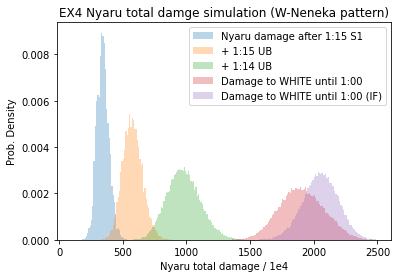

In [70]:
# Time: 1:23
ex4start = lambda x : nyaruUB(NYARU['attack'] + 19756, NYARU['critical']+180,0.15,400, detail=x)
print(ex4start(True))
histUB = []
nyaruUB_ex4 = lambda x,y,z : nyaruUB(NYARU['attack'] + x, NYARU['critical']+y,z,400, detail=False)
nyaruUB_ex4WHITE = lambda x,y,z : nyaruUB(NYARU['attack'] + x, NYARU['critical']+y,z,400, detail=False, magic_defense=80)
DEBUG_FLAG = True
LUNA_EX4 = LUNA_3
for ev in range(0,100000):
  # UB time: 1:23, 1:21, 1:21, 1:15, 1:14, 1:11, 1:11/1:08
  # Nyaru Skill: S2, S1/x, A, S1, S2/x, A, S1, A, A, S1
  # Array: UB/1:23, UB/1:21, UB/1:21, attack, S1, UB/1:15, UB/1:14, UB/1:11, UB/1:11or1:08
  nyaruDamage = [0] * 11
  #1:25 before Nuneka
  otherBuff = (28+10.5) * (LV_MAX +1) 
  nunekaAttack = 7168 + 240 + 15 * LV_MAX # 5star, Rand12 with TP equiment ONLY
  nunekaBuff = 10.5 * (LV_MAX + 1) + (nunekaAttack + otherBuff) * 0.08
  nunekaCriticalBuff = 30 + 0.003 * (nunekaAttack + otherBuff)
  otherCriticalBuff = nunekaCriticalBuff
  otherCriticalDamageBuff = 0.1 # Nuneka UB
  #1:23 Nyaru 1st UB
  otherBuff +=  nunekaBuff + (18 + 6) * (LV_MAX +1) #Saren S1 (until 1:03) + Nyaru S2 (until 1:11)
  nyaruBuff = otherBuff + 20. * (LV_MAX +1) # Nuneka S1 (until 1:11)
  nyaruCriticalBuff = nunekaCriticalBuff + 100 # Nuneka S1 (until 1:11)
  nyaruCriticalDamageBuff = otherCriticalDamageBuff + 0.05 # Nuneka S1 (until 1:11)
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF # until 1:05
  nyaruDamage[0] = ubDamage
    #DEBUG
  if(DEBUG_FLAG):
    print('Nyaru start UB : ' + repr(nyaruUB(NYARU['attack'] + nyaruBuff, NYARU['critical']+180,0.15,400,detail=True)))
  # 1:22 - Nuneka 2nd UB
  nunekaBuff = 10.5 * (LV_MAX + 1) + (nunekaAttack + otherBuff) * 0.08
  nunekaCriticalBuff = 30 + 0.003 * (nunekaAttack + otherBuff)
  otherBuff += nunekaBuff
  otherCriticalBuff += nunekaCriticalBuff
  otherCriticalDamageBuff += 0.1
  #1:21 - Nyaru 2nd/3rd UB by Luna S1
  nyaruBuff += 7.5 * (LV_MAX +1)
  nyaruCriticalBuff += nunekaCriticalBuff + 100
  nyaruCriticalDamageBuff += 0.1
    #2nd UB
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[1] = ubDamage
    # 3rd UB
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[2] = ubDamage
    # Luna damage
  nyaruHurt = LunaS1(LUNA_EX4['attack'] + otherBuff, NYARU['defence_magic'], LUNA_EX4['critical']+otherCriticalBuff, otherCriticalDamageBuff)
  lunaCriticalRate = critical_rate(LUNA_EX4['critical'] + otherCriticalBuff, LV_MAX)
  if(DEBUG_FLAG):
    print('Luna critical rate at 1:21 : ' + repr(lunaCriticalRate))
    print('Luna hit Nyaru : ' + repr(nyaruHurt))
  # 1:18 Nyaru Attack
  nyaruDamage[3] = critical_damage(
      NYARU['attack'] + nyaruBuff,
      critical_rate(NYARU['critical'] + nyaruCriticalBuff, 400),
      nyaruCriticalDamageBuff )
  # Nyaru HP check
  nyaruHpAbsorbRate = 6. / (100 + 400 + 6)
  if sum(nyaruDamage[1:4]) * nyaruHpAbsorbRate < nyaruHurt:
    histUB.append(nyaruDamage)
    DEBUG_FLAG = False
    continue
  # 1:15 Nyaru S1
  nyaruDamage[4] =NyaruS1(NYARU['attack'] + nyaruBuff, 0, NYARU['critical'] + nyaruCriticalBuff, nyaruCriticalDamageBuff, 400)
  nyaruDamageWHITE = NyaruS1(NYARU['attack'] + nyaruBuff, 80, NYARU['critical'] + nyaruCriticalBuff, nyaruCriticalDamageBuff, 400)
  nyaruDamageWHITE += NyaruS1(NYARU['attack'] + nyaruBuff, 50, NYARU['critical'] + nyaruCriticalBuff, nyaruCriticalDamageBuff, 400)
  nyaruDamageWHITE += NyaruS1(NYARU['attack'] + nyaruBuff, 50, NYARU['critical'] + nyaruCriticalBuff, nyaruCriticalDamageBuff, 400)
  # 1:15 Saren S2
  otherBuff += 2.5 * (LV_MAX + 1)
  otherCriticalBuff += 20
  nyaruBuff += 2.5 * (LV_MAX + 1)
  nyaruCriticalBuff += 20
  # 1:14 Nyaru 4/5th UB by Luna S1
    # Luna S1
  nyaruHurt = LunaS1(LUNA_EX4['attack'] + otherBuff, NYARU['defence_magic'], LUNA_EX4['critical']+otherCriticalBuff, otherCriticalDamageBuff)
  if(DEBUG_FLAG):
    lunaCriticalRate = critical_rate(LUNA_EX4['critical'] + otherCriticalBuff, LV_MAX)
    print('Luna critical rate at 1:15 : ' + repr(lunaCriticalRate))
    print('Luna hit Nyaru : ' + repr(nyaruHurt))
  nyaruBuff += 7.5 * (LV_MAX +1)
  nyaruCriticalBuff += 100
    # Nyaru 4th UB
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[5] = ubDamage
    # Nyaru 5th UB (TP check)
  nyaruTPrise = 1 + NYARU['tp_rise'] / 100. + 0.15 + 0.05 # Nenek UB + Nuneka UB x2
  nyaruTP = round(90 * nyaruTPrise) * 2 + 170
  if(nyaruHurt < (1000 - nyaruTP) / 500. / nyaruTPrise * NYARU['hp']):
    histUB.append(nyaruDamage)
    DEBUG_FLAG = False
    continue
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[6] = ubDamage
  # Kill BLACK and MOVE to WHITE
  # 1:14 Saren UB
  otherBuff += 10.5 * (LV_MAX + 1)
  nyaruBuff += 10.5 * (LV_MAX + 1)
  # 1:14 Nuneka S1
  nyaruBuff += 20. * (LV_MAX +1)
  nyaruCriticalBuff += 100
  nyaruCriticalDamageBuff += 0.05
  # 1:13 Buff check - Saren UB at 1:25
  otherBuff -= 10.5 * (LV_MAX + 1)
  nyaruBuff -= 10.5 * (LV_MAX + 1)  
  # 1:12 Nyaru Attack to WHITE + 1:15 S1 AOE to 3 targets
  nyaruDamage[7] = nyaruDamageWHITE + critical_damage(NYARU['attack'] + nyaruBuff, critical_rate(NYARU['critical'] + nyaruCriticalBuff, 400), nyaruCriticalDamageBuff, 2.0, 80)
  # 1:11 Luna S1
  nyaruHurt = LunaS1(LUNA_EX4['attack'] + otherBuff, NYARU['defence_magic'], LUNA_EX4['critical']+otherCriticalBuff, otherCriticalDamageBuff)
  if(nyaruHurt > NYARU['hp'] or DEBUG_FLAG):
    print('> TL check - Nyaru killed by Luna at 1:11 (%d, %d)' % (nyaruHurt, NYARU['hp']))
  if(DEBUG_FLAG):
    lunaCriticalRate = critical_rate(LUNA_EX4['critical'] + otherCriticalBuff, LV_MAX)
    print('Luna critical rate at 1:11 : ' + repr(lunaCriticalRate))
    print('Luna hit Nyaru : ' + repr(nyaruHurt))
  nyaruBuff += 7.5 * (LV_MAX +1)
  nyaruCriticalBuff += 100
  # 1:11 Nyaru 6th UB
  ubDamage = nyaruUB_ex4WHITE(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruBuff += ubDamage * NYARU_UB_BUFF_COEFF
  nyaruDamage[8] = ubDamage
  # 1:11 Neneka + Nuneka UB
  otherBuff += 28 * (LV_MAX + 1)
  nyaruBuff += 28 * (LV_MAX + 1)
  nunekaBuff = 10.5 * (LV_MAX +1) + (nunekaAttack +otherBuff) * 0.08
  nunekaCriticalBuff += 30 + (nunekaAttack +otherBuff) * 0.003
  otherBuff += nunekaBuff
  otherCriticalBuff += nunekaCriticalBuff
  otherCriticalDamageBuff += 0.1
  nyaruBuff += nunekaBuff
  nyaruCriticalBuff += nunekaCriticalBuff
  nyaruCriticalDamageBuff += 0.1
  # 1:11 Nyaru 7th UB
  ubDamage = nyaruUB_ex4WHITE(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruDamage[9] = ubDamage
  # 1:08 Nyaru 7th UB (IF)
    #Buff check (1:23 Nuneka, 1:21 Luna)
  nyaruBuff -= 20. * (LV_MAX +1)
  nyaruCriticalBuff -= 100
  nyaruCriticalDamageBuff -= 0.05
  nyaruBuff -= 7.5 * (LV_MAX +1)
  nyaruCriticalBuff -= 100
  ubDamage = nyaruUB_ex4(nyaruBuff, nyaruCriticalBuff, nyaruCriticalDamageBuff)
  nyaruDamage[10] = ubDamage
  # END
  histUB.append(nyaruDamage)
  DEBUG_FLAG = False


hurtFlag = [int(bool(x[4])) for x in histUB]
counts, binedges = np.histogram(hurtFlag, bins=[-0.5,0.5,1.5])
print(' > TL check - Nyaru HP at 1:18 [FAIL, PASS] =[%d vs %d]' % (counts[0], counts[1]))

successFlag = [int(bool(x[6])) for x in histUB]
counts, binedges = np.histogram(successFlag, bins=[-0.5,0.5,1.5])
print(' > TL check - Nyaru TP at 1:14 [FAIL, PASS] =[%d vs %d]' % (counts[0], counts[1]))

fig, ax = plt.subplots()
damageSumBefore115 = [ sum(x[0:5])/10000. for x in histUB if x[4] > 0]
damageSum115 = [ sum(x[0:6])/10000. for x in histUB if x[5] > 0]
damageSum114 = [ sum(x[0:7])/10000. for x in histUB if x[6] > 0]
damageSumWHITE = [(x[7]+x[8]+x[9])/10000 + 500 for x in histUB if x[7] > 0]
damageSumWHITE_if = [(x[7]+x[8]+x[10])/10000 + 500 for x in histUB if x[7] > 0]
pltKwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=range(100,2500,10))
histBefore115 = plt.hist(damageSumBefore115, **pltKwargs, label='Nyaru damage after 1:15 S1')
hist115 = plt.hist(damageSum115, **pltKwargs, label='+ 1:15 UB')
hist114 = plt.hist(damageSum114, **pltKwargs, label='+ 1:14 UB')
histWHITE = plt.hist(damageSumWHITE, **pltKwargs, label='Damage to WHITE until 1:00')
histWHITE_if = plt.hist(damageSumWHITE_if, **pltKwargs, label='Damage to WHITE until 1:00 (IF)')
leg = ax.legend()
plt.title('EX4 Nyaru total damge simulation (W-Neneka pattern)')
plt.ylabel('Prob. Density')
plt.xlabel('Nyaru total damage / 1e4')

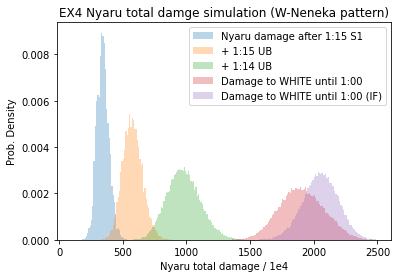

In [71]:
# Optimize plots
fig, ax = plt.subplots()
pltKwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=range(100,2500,10))
histBefore115 = plt.hist(damageSumBefore115, **pltKwargs, label='Nyaru damage after 1:15 S1')
hist115 = plt.hist(damageSum115, **pltKwargs, label='+ 1:15 UB')
hist114 = plt.hist(damageSum114, **pltKwargs, label='+ 1:14 UB')
histWHITE = plt.hist(damageSumWHITE, **pltKwargs, label='Damage to WHITE until 1:00')
histWHITE_if = plt.hist(damageSumWHITE_if, **pltKwargs, label='Damage to WHITE until 1:00 (IF)')
leg = ax.legend()
plt.title('EX4 Nyaru total damge simulation (W-Neneka pattern)')
plt.ylabel('Prob. Density')
plt.xlabel('Nyaru total damage / 1e4')
plt.savefig('pcr_ex4.png')

In [72]:
# Damage and buff check
print(LunaS1(LUNA_4['attack'] + 6 *(LV_MAX +1), NYARU['defence_magic'], LUNA_4['critical'] ))
print(nyaruUB(NYARU['attack'] + 19756, NYARU['critical']+180,0.15,enemyLv=400, lv=LV_MAX,detail=True, magic_defense=0))
print((nunekaAttack + (10.5 + 28 + 10.5 + 2.5) *(LV_MAX+1) +1300) * 0.003)
print(critical_rate(LUNA_4['critical'] + 30 + 70, LV_MAX))

9695
[15403, 61611, 280334.0]
65.979
0.7160000000000001


In [73]:
# HP absord check
print(14808/nyaruHpAbsorbRate)
print(14808./1249290)
print(3367./294031)

1248808.0
0.011853132579305046
0.011451173515717731


In [74]:
# Luna attack check (if crtical to kill Nyaru)
LunaAttack115 = round(23115 / 2.4 * 3.88)
overHP = (LunaAttack115 - (LUNA_4['attack'] - LUNA_3['attack']) + 6 * (LV_MAX +1))/ 3.88 * 2.4 - NYARU['hp']
print(overHP + NYARU['hp'])
LUNA_4['attack'] - LUNA_3['attack']
testOverHP = 23656 - NYARU['hp']
13873 - (testOverHP * 3.88 / 2.4) 

23502.061855670105


14194.716666666667

#### Nyaru TP check
* 1:15 Luna MUST hit **CRITICAL** at Nyaru
* 1:11 PASS with NO critical
* 1:00/0:58 WHITE perform All hit to Nyaru (if not, still OK at 0:57 with Luna S1)
* 0:44 Luna MUST hit **CRITICAL** + **1 hits** from WHITE boss

*ISSUE*: Nyaru hurt from WHITE at 0:44 is 1733/hit but not 1922 (calculated from data). IF SLv of Main 4 (WHITE) should be 250 not 500?
**SOLVED**: Buff clear at 1:00 was cancelled as well as the self buff.

In [69]:
# Nyaru TP check
# 1:15
tpRise = 15 + 5 *2 + NYARU['tp_rise']
hurtNyaru = hurt_for_UB(2, tpRise, NYARU['tp_rest'], NYARU['hp'], NYARU['defence_magic'], 0)
print('Damage required at 1:15 - %d' % hurtNyaru)
# 1:11
tpRise = 15 + 5*2 + NYARU['tp_rise']
hurtNyaru = hurt_for_UB(1, tpRise, NYARU['tp_rest'], NYARU['hp'], NYARU['defence_magic'], 
                        kill_tp(tpRise) + nuneka_tp(tpRise))
print('Damage required at 1:11 - %d' % hurtNyaru)
# 1:00
tpRise = 15 + 5 + NYARU['tp_rise']
tpRise108 = 15 * 2 + 5*3 + NYARU['tp_rise']
tpRise106 = 15 + 5*2 + NYARU['tp_rise']
hurtNyaru = hurt_for_UB(3, tpRise, NYARU['tp_rest'], NYARU['hp'], NYARU['defence_magic'],
                        nuneka_tp(tpRise108) +action_tp(tpRise106) )
print('Damage required at 1:00 - %d' % hurtNyaru)
print('> Nuneka TP boost at 1:07 = %d'  % nuneka_tp(tpRise108))
whiteS1 = 100 + 50 * 400 + (0.1 + 0.0005 * 400) * 5000
print('> Nyaru hurt per hit from WHITE S1 - %d' % (whiteS1/4/(1+NYARU['defence_magic']/100.)))
print('> WHITE damage at 1:00 - %d, %d, %d, %d' % (whiteS1/4, whiteS1/2, whiteS1*3/4, whiteS1))
# 0:44
tpRise = 15 + 5 + NYARU['tp_rise']
hurtNyaru = hurt_for_UB(3, tpRise, NYARU['tp_rest'], NYARU['hp'], NYARU['defence_magic'], 0)
print('Damage required at 0:44 - %d' % hurtNyaru)
whiteS1 = 100 + 50 * 400 + (0.1 + 0.0005 * 400) * (5000 +1 + 40 *500)
print('> Nyaru hurt per hit from WHITE S1 - %d' % (whiteS1/4/(1+NYARU['defence_magic']/100.)))
print('> WHITE damage at 0:44 - %d, %d, %d, %d' % (whiteS1/4, whiteS1/2, whiteS1*3/4, whiteS1))
nunekaAttack053 = NUNEKA_ATTACK + (28 * 2 + 10.5 + 10.5 + 2.5) * (LV_MAX +1)  # delta from 111
lunaAttack = LUNA_3['attack'] + (28 + 10.5 + 10.5 + 2.5) * (LV_MAX +1) + nunekaAttack053 * 0.08
print('> Luna damage at 0:44 - %d, %d/critical' % (lunaAttack, lunaAttack * 2 * 1.1))
hurtNyaru = hurt_for_UB(2, tpRise, NYARU['tp_rest'], NYARU['hp'], NYARU['defence_magic'], 0)
print('> (IF) Damage required at 0:44 - %d' % hurtNyaru)
# 0:19
tpRise = 15 +5 + NYARU['tp_rise']
hurtNyaru = hurt_for_UB(4, tpRise, NYARU['tp_rest'], NYARU['hp'], NYARU['defence_magic'], nuneka_tp(tpRise))
print('Damage required at 0:19 - %d' % hurtNyaru)
whiteS1 = 100 + 50 * 400 + (0.1 + 0.0005 * 400) * (5000 + 25 * 400 +1 + 40 *500)
print('> Nyaru hurt per hit from WHITE S1 - %d' % (whiteS1/4/(1+NYARU['defence_magic']/100.)))
print('> WHITE damage at 0:19 - %d, %d, %d, %d' % (whiteS1/4, whiteS1/2, whiteS1*3/4, whiteS1))
hurtNyaru = hurt_for_UB(3, tpRise, NYARU['tp_rest'], NYARU['hp'], NYARU['defence_magic'], nuneka_tp(tpRise))
print('> Damage required at 0:19 (Nyaru 3 actions ONLY) - %d' % hurtNyaru)

Damage required at 1:15 - 80082
Damage required at 1:11 - 33023
Damage required at 1:00 - 18417
> Nuneka TP boost at 1:07 = 217
> Nyaru hurt per hit from WHITE S1 - 1356
> WHITE damage at 1:00 - 5400, 10800, 16200, 21600
Damage required at 0:44 - 67102
> Nyaru hurt per hit from WHITE S1 - 1733
> WHITE damage at 0:44 - 6900, 13800, 20700, 27600
> Luna damage at 0:44 - 29926, 65838/critical
> (IF) Damage required at 0:44 - 84235
Damage required at 0:19 - 23842
> Nyaru hurt per hit from WHITE S1 - 1922
> WHITE damage at 0:19 - 7650, 15300, 22950, 30600
> Damage required at 0:19 (Nyaru 3 actions ONLY) - 40975
